# Imports

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import sys
sys.path.append("..")

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from model.llm import LLM
from model.transformer import CosinePositionalEncoding, RMSNorm, SwiGLU, SelfAttention, MultiHeadAttention, FeedForward, TransformerBlock

# Model

In [31]:
bs, seq_len, dim_emb = 64, 32, 128
x = torch.randn((bs, seq_len, dim_emb))

## Check RMSNorm

In [85]:
rms_norm = RMSNorm(dim_emb)

print(f"total params: {sum(p.numel() for p in rms_norm.parameters())}")
print(f"learnable params: {sum(p.numel() for p in rms_norm.parameters() if p.requires_grad)}")
print(rms_norm)

with torch.no_grad():
    y = rms_norm(x)

print(f"{y.shape=}")

rms = torch.norm(x, dim=-1, keepdim=True) * (dim_emb**-0.5)
torch.allclose(x / rms, y)

total params: 256
learnable params: 256
RMSNorm()
y.shape=torch.Size([64, 32, 128])


True

## SwiGLU

In [76]:
swiglu = SwiGLU(dim_emb)

print(f"total params: {sum(p.numel() for p in swiglu.parameters())}")
print(f"learnable params: {sum(p.numel() for p in swiglu.parameters() if p.requires_grad)}")
print(swiglu)

with torch.no_grad():
    y = swiglu(x)
    
print(y.shape)

total params: 33024
learnable params: 33024
SwiGLU(
  (linear): Linear(in_features=128, out_features=256, bias=True)
)
torch.Size([64, 32, 128])


## Check positional encoding

total params: 0
learnable params: 0
CosinePositionalEncoding()
y.shape=torch.Size([64, 32, 128])


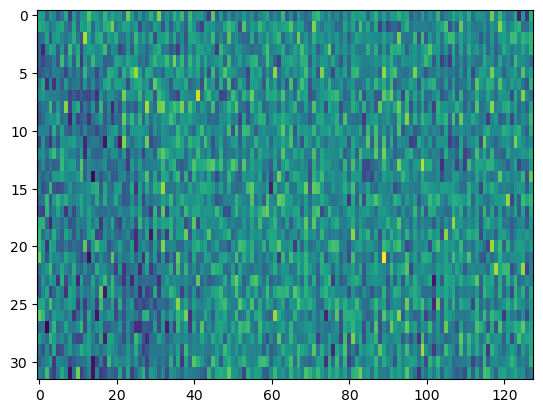

In [75]:
pos_encoding = CosinePositionalEncoding(seq_len, dim_emb)

print(f"total params: {sum(p.numel() for p in pos_encoding.parameters())}")
print(f"learnable params: {sum(p.numel() for p in pos_encoding.parameters() if p.requires_grad)}")
print(pos_encoding)

with torch.no_grad():
    y= pos_encoding(x)

print(f"{y.shape=}")

plt.imshow(y[0, ...], aspect="auto")

## Check self attention

total params: 65536
learnable params: 65536
SelfAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)


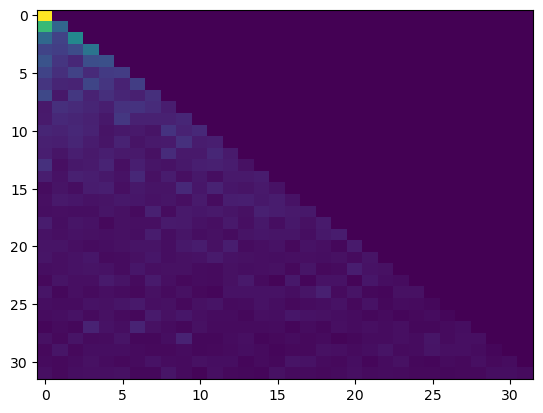

In [74]:
self_attn = SelfAttention(seq_len, dim_emb, causal=True)

print(f"total params: {sum(p.numel() for p in self_attn.parameters())}")
print(f"learnable params: {sum(p.numel() for p in self_attn.parameters() if p.requires_grad)}")
print(self_attn)

with torch.no_grad():
    y, attn_scores = self_attn(x, return_scores=True)

plt.imshow(attn_scores[0, ...], aspect="auto")

SelfAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)


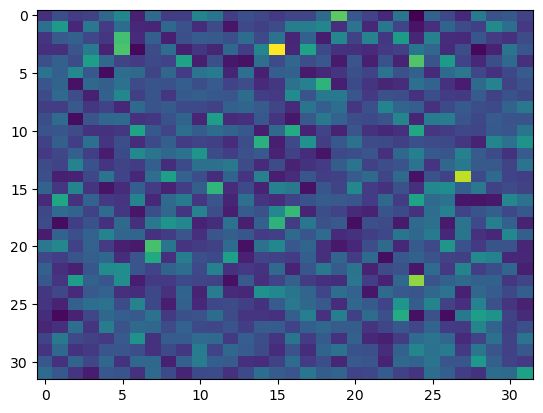

In [19]:
self_attn = SelfAttention(seq_len, dim_emb, causal=False)

print(self_attn)

with torch.no_grad():
    y, attn_scores = self_attn(x, return_scores=True)

plt.imshow(attn_scores[0, ...], aspect="auto")

## Check multihead attention

total params: 65536
learnable params: 65536
MultiHeadAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)
torch.Size([64, 32, 128])
torch.Size([64, 2, 32, 32])


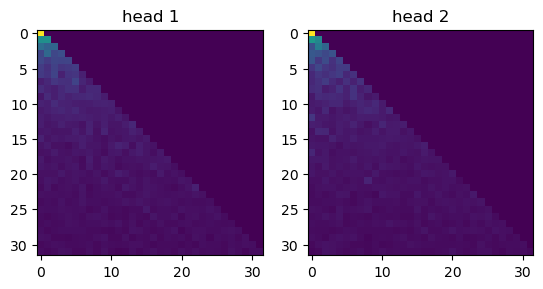

In [73]:
mha = MultiHeadAttention(seq_len, num_heads=2, dim_emb=dim_emb, causal=True)

print(f"total params: {sum(p.numel() for p in mha.parameters())}")
print(f"learnable params: {sum(p.numel() for p in mha.parameters() if p.requires_grad)}")
print(mha)

with torch.no_grad():
    y, attn_scores = mha(x, return_scores=True)


print(y.shape)
print(attn_scores.shape)

fig, axes = plt.subplots(1, mha.num_heads)

for h in range(mha.num_heads):
    axes[h].imshow(attn_scores[0, h, ...], aspect="equal")
    axes[h].set_title(f"head {h+1}")

## Check feedforward

In [72]:
ffd = FeedForward(dim_emb, dim_emb, num_hidden=2)

print(f"total params: {sum(p.numel() for p in ffd.parameters())}")
print(f"learnable params: {sum(p.numel() for p in ffd.parameters() if p.requires_grad)}")
print(ffd)

with torch.no_grad():
    y = ffd(x)

print(x.shape)
print(y.shape)

total params: 66304
learnable params: 66304
FeedForward(
  (_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): RMSNorm()
    (2): SwiGLU(
      (linear): Linear(in_features=128, out_features=256, bias=True)
    )
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
)
torch.Size([64, 32, 128])
torch.Size([64, 32, 128])


## Check Transformer block

In [71]:
transformer = TransformerBlock(seq_len, dim_emb, attn_num_heads=2, attn_causal=True)

print(f"total params: {sum(p.numel() for p in transformer.parameters())}")
print(f"learnable params: {sum(p.numel() for p in transformer.parameters() if p.requires_grad)}")
print(transformer)

with torch.no_grad():
    y = transformer(x)

print(x.shape)
print(y.shape)

total params: 132352
learnable params: 132352
TransformerBlock(
  (pos_encoding): CosinePositionalEncoding()
  (norm_1): RMSNorm()
  (multihead_attn): MultiHeadAttention(
    (projection_query): Linear(in_features=128, out_features=128, bias=False)
    (projection_key): Linear(in_features=128, out_features=128, bias=False)
    (projection_value): Linear(in_features=128, out_features=128, bias=False)
    (projection_out): Linear(in_features=128, out_features=128, bias=False)
  )
  (norm_2): RMSNorm()
  (feed_forward): FeedForward(
    (_layers): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): RMSNorm()
      (2): SwiGLU(
        (linear): Linear(in_features=128, out_features=256, bias=True)
      )
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)
torch.Size([64, 32, 128])
torch.Size([64, 32, 128])


## Check LLM

In [70]:
vocab_size = 1000
probs = torch.repeat_interleave(torch.Tensor([1 / vocab_size] * vocab_size).unsqueeze(0), 64, dim=0)
sequences = torch.multinomial(input=probs, num_samples=seq_len, replacement=True)

llm = LLM(vocab_size=vocab_size, seq_len=seq_len, dim_emb=dim_emb, num_layers=2, attn_num_heads=2, attn_causal=True)

print(f"total params: {sum(p.numel() for p in llm.parameters())}")
print(f"learnable params: {sum(p.numel() for p in llm.parameters() if p.requires_grad)}")
print(llm)

with torch.no_grad():
    y = llm(sequences)

print(x.shape)
print(y.shape)

total params: 521704
learnable params: 521704
LLM(
  (token_embedding): Embedding(1000, 128)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (pos_encoding): CosinePositionalEncoding()
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (projection_query): Linear(in_features=128, out_features=128, bias=False)
        (projection_key): Linear(in_features=128, out_features=128, bias=False)
        (projection_value): Linear(in_features=128, out_features=128, bias=False)
        (projection_out): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): RMSNorm()
          (2): SwiGLU(
            (linear): Linear(in_features=128, out_features=256, bias=True)
          )
          (3): Dropout(p=0.0, inplace=False)
          (4)